<h3>The purpose of this notebook is to begin applying some basic clustering and dimensionality reduction techniques.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from sklearn.metrics import pairwise_distances
import yellowbrick.cluster
from yellowbrick.cluster import SilhouetteVisualizer

print('Pandas version used: ' + pd.__version__)
print('Numpy version used: ' + np.__version__)
print('SKLearn version used: ' + sklearn.__version__)
print('Matplotlib version used: ' + matplotlib.__version__)
print('Yellowbrick version used: ' + yellowbrick.__version__)

Pandas version used: 1.0.5
Numpy version used: 1.18.5
SKLearn version used: 0.23.1
Matplotlib version used: 3.2.2
Yellowbrick version used: 1.1


C:\Users\Me\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Read in the gene expression information:
gene_df = pd.read_csv('gene_datasets/gene_data.csv', index_col=0)

In [3]:
# Read in the label dataframe. This contains the labels of the type of tumor associated with the sample:
label_df = pd.read_csv('gene_datasets/gene_labels.csv', index_col=0)

Before applying any other dimensionality reduction or feature engineering, I will apply the KMeans clustering algorithim just to see what kind of results we get as a baseline.

I am selecting KMeans because it is a quick and efficient algorithim and I already have an idea of how many clusters I should select. Additionally, no scaling is necessary since the data is already scaled versus an arbitrary reference gene.

I am concerned about the 'curse of dimensionality' in this dataset since there are over 20,000 dimensions to consider. It might be worthwhile, if the kmeans clustering is not effective, to do PCA and rerun the algorithim.

Any future clustering can be measured against this baseline of the KMean results to see if they result in any significant improvements.

Since I already know this dataset contains samples of 5 different types of tumors, I will start with n_clusters=5.

In [4]:
# Set up the initial KMeans settings with 5 clusters, random initialization,
# and a max of 100 iterations so we don't spend forever on it:
genes_km = KMeans(n_clusters=5,
                  init='random',
                  max_iter=100)

In [5]:
# Fit the model to the dataframe:
genes_km_clust = genes_km.fit_predict(gene_df)

In [6]:
# Create a new version of the dataframe so we can apply the labels and add a column of the first kmean clustering results:
labeled_gene_df = gene_df.copy()

In [7]:
# Add the tumor type labels from the label_df:
labeled_gene_df.insert(0, 'tumor_type', label_df)

In [8]:
# Insert our first results from the kmean clustering as the kmean_base:
labeled_gene_df.insert(1, 'kmean_base', genes_km_clust)

In [9]:
# Take a look at the new df with the labels and kmean_base columns:
labeled_gene_df.head()

,tumor_type,kmean_base,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,PRAD,4,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,LUAD,1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,PRAD,4,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,PRAD,4,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,BRCA,3,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [10]:
# In order to get an idea of how close the first kmean clustering was to the actual tumor types, let's separate out
# each tumor type into its own dataframe:
labeled_gene_df_brca = labeled_gene_df[labeled_gene_df.tumor_type == 'BRCA']
labeled_gene_df_luad = labeled_gene_df[labeled_gene_df.tumor_type == 'LUAD']
labeled_gene_df_prad = labeled_gene_df[labeled_gene_df.tumor_type == 'PRAD']
labeled_gene_df_coad = labeled_gene_df[labeled_gene_df.tumor_type == 'COAD']
labeled_gene_df_kirc = labeled_gene_df[labeled_gene_df.tumor_type == 'KIRC']

In [11]:
# Print the unique values within the kmean_base column and their associated counts:
print('BRCA:',np.unique(labeled_gene_df_brca.kmean_base, return_counts=True))
print('LUAD:',np.unique(labeled_gene_df_luad.kmean_base, return_counts=True))
print('PRAD:',np.unique(labeled_gene_df_prad.kmean_base, return_counts=True))
print('COAD:',np.unique(labeled_gene_df_coad.kmean_base, return_counts=True))
print('KIRC:',np.unique(labeled_gene_df_kirc.kmean_base, return_counts=True))

BRCA: (array([1, 3]), array([  1, 299], dtype=int64))
LUAD: (array([1, 3]), array([139,   2], dtype=int64))
PRAD: (array([4]), array([136], dtype=int64))
COAD: (array([1, 2]), array([ 2, 76], dtype=int64))
KIRC: (array([0, 3]), array([145,   1], dtype=int64))


In [22]:
np.unique(labeled_gene_df_kirc.kmean_base, return_counts=True)

(array([0, 3]), array([145,   1], dtype=int64))

A bit unexpected-- the basic kmean clustering performed pretty much flawlessly in clustering the samples by the type of tumor the sample was associated with. Only 1 or 2 from each tumor sample were clustered differently

This is good news, since it seems to suggest that the gene expression levels amongst the different tumor samples follow a specific pattern that could perhaps be used to direct treatments or diagnose patients.

In [12]:
# Just for completeness' sake, let's check the silhouette score for this model:
metrics.silhouette_score(gene_df, genes_km.labels_)

0.22469293361216375

The silhouette score is not terribly good, but that's not surprising given how many dimensions this dataset has. The fact that it is not negative, at least, is a good sign but there is probably a good bit of overlap.

According to the documentation, the silhouette score is best for convex clusters which we are unlikely to have.

Fortunately, we have some degree of 'ground truth' with the sample labels.

In [13]:
# Let's also check the inertia:
genes_km.inertia_

17801949.109766033

The inertia is extremely high, but this is expected with a dataset of this many dimensions.

Since that first attempt at clustering was so successful already, I will move on to attempting to cluster the transposed form of the gene dataframe.

With that I will attempt to cluster the genes together based off of their levels of expression across the 801 samples. Genes that cluster together might activate one another or work together towards some kind of function that could be related to the formation/growth of the tumors.

From the journal article, Clustering Algorithms: Their Application to Gene Expression Data: "patterns have been detected with genes, making it easier to pick out genes with related functions."

Treatments that address multiple genes might be more effective than those at only target a few.

Since there is not an obvious number of clusters to select for the genes, I will need to find an optimal number of clusters to organize the genes into.

In [14]:
# Create a transposed version of the gene dataframe:
T_gene_df = gene_df.transpose()

In [15]:
# Make sure that worked as intended:
T_gene_df.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_791,sample_792,sample_793,sample_794,sample_795,sample_796,sample_797,sample_798,sample_799,sample_800
gene_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.436588,0.000000,0.000000,0.000000,0.000000,0.000000
gene_1,2.017209,0.592732,3.511759,3.663618,2.655741,3.467853,1.224966,2.854853,3.992125,3.642494,...,3.080061,4.337404,2.068224,4.288388,4.472176,1.865642,3.942955,3.249582,2.590339,2.325242
gene_2,3.265527,1.588421,4.327199,4.507649,2.821547,3.581918,1.691177,1.750478,2.772730,4.423558,...,2.815739,2.597126,0.857663,3.452490,4.908746,2.718197,4.453807,3.707492,2.787976,3.805932
gene_3,5.478487,7.586157,6.881787,6.659068,6.539454,6.620243,6.572007,7.226720,6.546692,6.849511,...,6.209617,6.070379,6.218739,7.209151,5.937848,7.350099,6.346597,8.185901,7.318624,6.530246
gene_4,10.431999,9.623011,9.870730,10.196184,9.738265,9.706829,9.640511,9.758691,10.488252,9.464466,...,9.644469,9.863990,10.623068,9.875620,9.330901,10.006003,10.056868,9.504082,9.987136,9.560367


To start out, I will use the elbow method using interia on the transposed dataframe to see if I can elucidate a decent value for k:

In [16]:
inertia_values = []
for n in range(1,20):
    km = KMeans(n_clusters = n,
                init = 'random',
                max_iter = 100)
    km.fit(T_gene_df)
    inertia_values.append(km.inertia_)

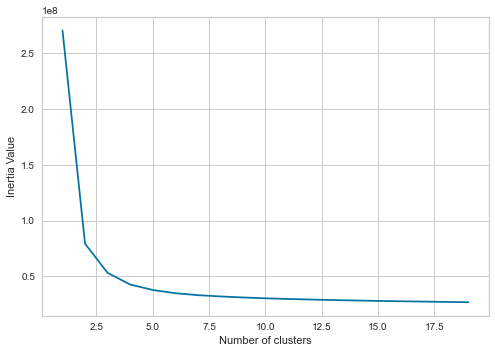

In [17]:
plt.plot(range(1,20), inertia_values, marker='x')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Value')
plt.show()

Based off of this plot, it seems to me that 2 or 3 might be the optimal number of clusters for the genes, but 4 and 5 might be worth looking at too. Let's start with 2 and 3 and then look at 4 and 5 clusters to compare.

It might also just be tough to determine a proper amount of clusters with so many dimensions (801).

C:\Users\Me\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B7F794D00>,
                     model=None)

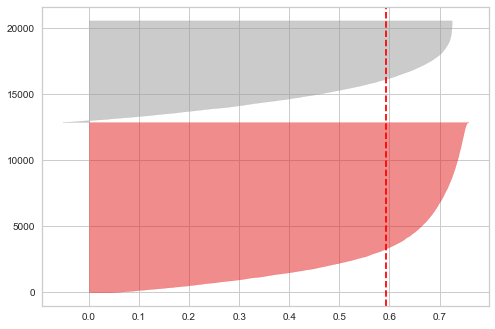

In [18]:
gene_exp_km_2 = KMeans(n_clusters = 2,
            init = 'random',
            max_iter = 100)
gene_exp_km_clust = gene_exp_km_2.fit_predict(T_gene_df)
sil_vis = SilhouetteVisualizer(gene_exp_km_2)
sil_vis.fit(T_gene_df)

C:\Users\Me\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B04D25D30>,
                     model=None)

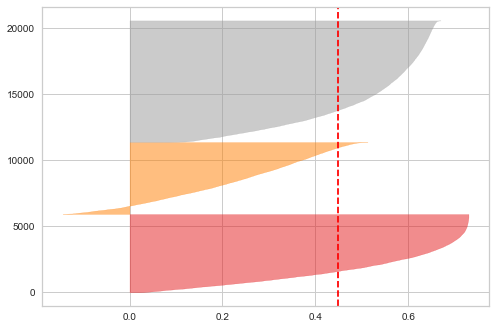

In [19]:
gene_exp_km_3 = KMeans(n_clusters = 3,
            init = 'random',
            max_iter = 100)
gene_exp_km_clust = gene_exp_km_3.fit_predict(T_gene_df)
sil_vis = SilhouetteVisualizer(gene_exp_km_3)
sil_vis.fit(T_gene_df)

Now let's plot the silhouette scores and see if k=4 works out well:

C:\Users\Me\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B74577AC0>,
                     model=None)

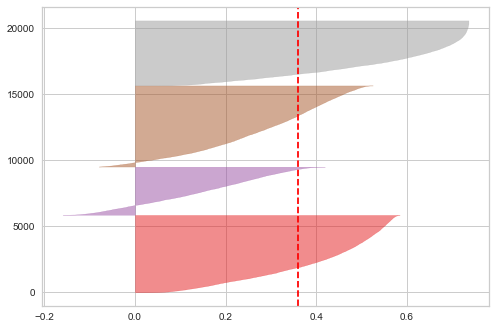

In [20]:
gene_exp_km_4 = KMeans(n_clusters = 4,
            init = 'random',
            max_iter = 100)
gene_exp_km_clust = gene_exp_km_4.fit_predict(T_gene_df)
sil_vis = SilhouetteVisualizer(gene_exp_km_4)
sil_vis.fit(T_gene_df)

Finally we'll see what kind of plot k=5 produces:

C:\Users\Me\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B74AD1FD0>,
                     model=None)

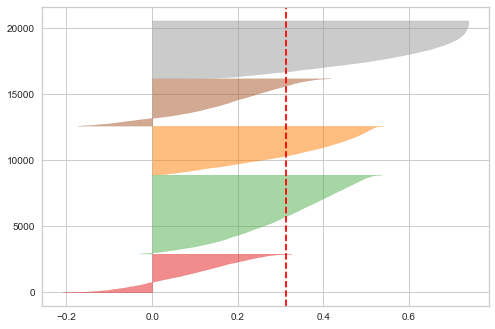

In [21]:
gene_exp_km_5 = KMeans(n_clusters = 5,
            init = 'random',
            max_iter = 100)
gene_exp_km_clust = gene_exp_km_5.fit_predict(T_gene_df)
sil_vis = SilhouetteVisualizer(gene_exp_km_5)
sil_vis.fit(T_gene_df)

It's tough to say definitively which cluster number is best, but it seems like it has to be either 2 or 3 based off of these plots. 4 and 5 have very inconsistent shapes and low overall silhouette scores.

It might be that KMeans is not a good choice for clustering the gene expressions together.